In [11]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

## Imports

In [154]:
# modified from test.ipynb and main.py

import time
from utils import plot_3d_boundary, plot_3d_observed_rewards
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

# Constraints
from emukit.core.constraints import LinearInequalityConstraint

In [155]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [14]:
from loop import *

## Experimental Setup

In [172]:
surge_modulator = 1.0
all_scenarios = {"Baseline (20 % Discount)": {"discharge_discount": 0.8,
                             "charging_discount": 1.05,
                             "surge_modulator": surge_modulator},
                "25 % Discount": {"discharge_discount": 0.75,
                             "charging_discount": 1.05,
                             "surge_modulator": surge_modulator},
                "33 % Discount": {"discharge_discount": 0.67,
                             "charging_discount": 1.05,
                             "surge_modulator": surge_modulator},
                "33 % Discount +": {"discharge_discount": 0.67,
                             "charging_discount": 1.0,
                             "surge_modulator": surge_modulator},
                "50 % Discount": {"discharge_discount": 0.5,
                             "charging_discount": 1.05,
                             "surge_modulator": surge_modulator}}

scenario = "50 % Discount"

In [145]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }
    
    kwargs.update(all_scenarios[scenario])

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [99]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [54]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = 5
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

In [55]:
# Basic plotting function

def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.view_init(90, 90)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Run Experiments

In [56]:
from scse.default_run_parameters.national_grid_default_run_parameters import DEFAULT_RUN_PARAMETERS

In [168]:
max_num_batteries = 1500

# units in £/
min_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty - 100000
max_battery_penalty = DEFAULT_RUN_PARAMETERS.battery_penalty + 200000

min_battery_capacity = 1
max_battery_capacity = 80

num_data_points = 10

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1

min_time_horizon_value = timesteps_per_week * 1
max_time_horizon_value = timesteps_per_week * 2

num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))
battery_penalty = DiscreteParameter(
    'battery_penalty', range(min_battery_penalty, max_battery_penalty+1))
time_horizon = DiscreteParameter('time_horizon', range(min_time_horizon_value, max_time_horizon_value+1))

#parameters = [num_batteries, max_battery_capacities, time_horizon, battery_penalty]
parameters = [num_batteries]
parameter_space = ParameterSpace(parameters)

In [169]:
# Get and check the parameters of the intial values (X)

design = RandomDesign(parameter_space)
X = design.get_samples(num_data_points)
X

array([[ 980],
       [1212],
       [ 170],
       [1132],
       [ 620],
       [ 472],
       [1130],
       [ 944],
       [ 468],
       [ 932]])

### Get initial data points

In [173]:
design = RandomDesign(parameter_space)

start = time.time()
Y = f_multiprocess(X)
end = time.time()
print("Getting {} initial simulation points took {} seconds".format(
    num_data_points, round(end - start, 0)))

  0%|          | 0/10 [00:00<?, ?it/s]

Getting 10 initial simulation points took 78.0 seconds


### Check the cum. reward from the initial points to ensure we are seeing reasonable behaviour before fitting

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:xlabel='num_batteries', ylabel='Cumulative reward'>)

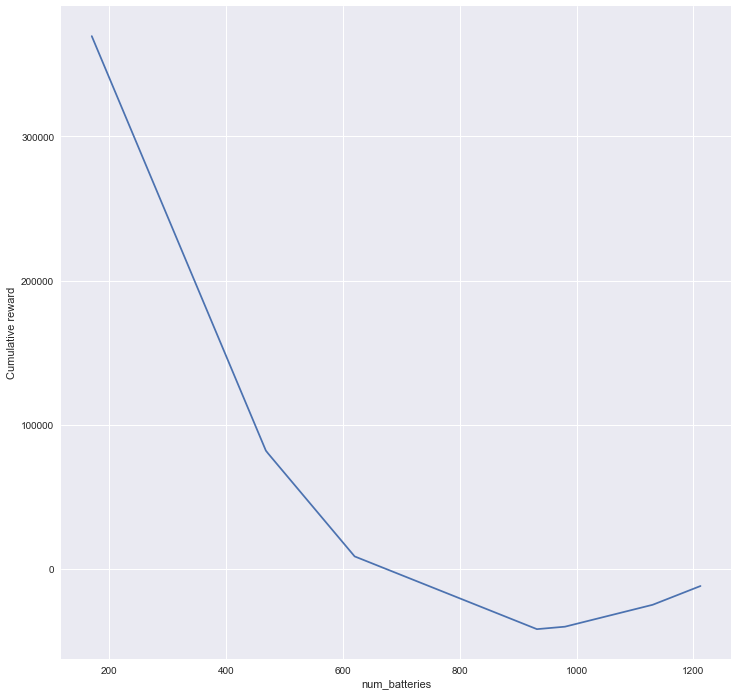

In [174]:
plot_reward(X, Y, parameter_space.parameter_names)

### Run BO

In [179]:
successful_sample = False
num_tries = 0
max_num_tries = 3

use_default= False
use_ard=False

while not successful_sample and num_tries < max_num_tries: 
    
    print(f"CURRENT ATTEMPT #{num_tries}")
    
    # emulator model

    if use_default: 
        gpy_model = GPRegression(X, Y)
    else: 
        kernel = GPy.kern.RBF(1, lengthscale=1e2, variance=1e4, ARD=use_ard)
        gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    
    try: 
        gpy_model.optimize()
        print("okay to optimize")
        model_emukit = GPyModelWrapper(gpy_model)

        # Load core elements for Bayesian optimization
        expected_improvement = ExpectedImprovement(model=model_emukit)
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                 space=parameter_space,
                                                 acquisition=expected_improvement,
                                                 batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.0001)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("successfully ran loop")
        successful_sample = True
        
    except: 
        num_tries += 1 


INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:emukit.core.loop.stopping_conditions:Stopped as consecutive evaluations are within 0.0001
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.loop.outer_loop:Finished outer loop


successfully ran loop


### Get new points from BO

In [180]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]

### Plot results from BO with the GP fit

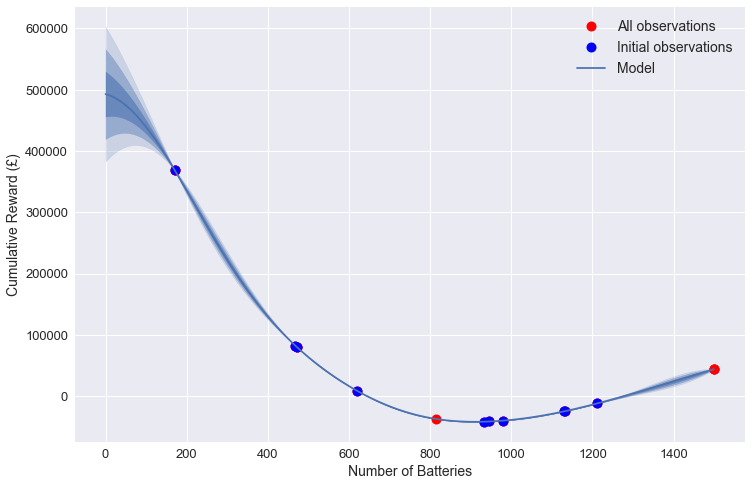

In [181]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
#plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(prop={'size': 14})
plt.xlabel("Number of Batteries", fontsize=14)
plt.ylabel("Cumulative Reward (£)", fontsize=14)
plt.grid(True)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

In [182]:
new_X

array([[ 170.],
       [ 170.],
       [ 468.],
       [ 472.],
       [ 472.],
       [ 620.],
       [ 814.],
       [ 932.],
       [ 944.],
       [ 980.],
       [1130.],
       [1132.],
       [1212.],
       [1500.],
       [1500.],
       [1500.]])

Base Scenario: minimum is 406 batteries
Scenario: 25% discount: minimum is 564 batteries
Scenario: 33% discount: minimum is 720 batteries
Scenario: 33% discount+: minimum is 646 batteries
Scenario: 50% discount: minimum is 932 batteries

For 2D battery_penalty: (used (100,200) and for first prior and (100,10) for second.)
For 2D max_battery-capacity: used normal ones Max found